Kilian Cannet - Noe Boonstra

# Importation

In [55]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

# Chargement données

In [2]:
#https://www.kaggle.com/priteshshrivastava/sample-github-code
data = pd.read_csv("sample_code.csv", lineterminator='\n',names=['content','lang'])

pd.set_option('display.max_colwidth', None)

from IPython.display import display, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>").replace("\\r","").replace("\\t","    ")) )

pretty_print(data.head(5))

,content,lang
0,content,type
1,"// Utility.cs//using System;using System.Html;namespace AroundMe.Core { internal static class Utility { public static Element GetElement(string id) { return Document.GetElementById(id); } public static void SubscribeBlur(string id, ElementEventListener listener) { Element e = Document.GetElementById(id); e.AddEventListener(""blur"", listener, false); } public static void SubscribeClick(string id, ElementEventListener listener) { Element e = Document.GetElementById(id); e.AddEventListener(""click"", listener, false); } public static void SubscribeKey(string id, ElementEventListener listener) { Element e = Document.GetElementById(id); e.AddEventListener(""keyup"", listener, false); } }}",cs
2,"{$options.identity.sitename} - Your Accounts====================================================To whom it may concern,You, or someone purporting to be you, has requested a username reminder for your email address for {$options.identity.sitename}.The usernames linked to your account are:{foreach $users as $u}* {$u->getUsername()} - (for {$u->getCustomer()->getName()}){/foreach}If you did not make this request, please contact our support team.Thanks and kind regards,{$options.identity.name}{$options.identity.email}",txt
3,"{ ""name"": ""opulence/sessions"", ""description"": ""The Opulence session library"", ""keywords"": [ ""PHP"", ""session"" ], ""authors"": [ { ""name"": ""David Young"", ""email"": ""dave@opulencephp.com"", ""role"": ""Architect"" } ], ""license"": ""MIT"", ""autoload"": { ""psr-4"": { ""Opulence\\Sessions\\"": """" } }, ""require"": { ""php"": "">=7.0.0"" }, ""suggest"": { ""opulence/cache"": ""Required for CacheSessionHandler"", ""opulence/cryptography"": ""Required for SessionEncrypter"" }, ""extra"": { ""branch-alias"": { ""dev-master"": ""1.0.x-dev"" } }, ""minimum-stability"": ""dev""}",json
4,"package io.mycat.backend.postgresql.packet;import java.nio.ByteBuffer;import io.mycat.backend.postgresql.utils.PIOUtils;// BindComplete (B)// Byte1('2')// 标识消息为一个绑定结束标识符。// // Int32(4)// 以字节记的消息长度，包括长度本身。/*** * 绑定预编译sql成功 * @author Coollf * */public class BindComplete extends PostgreSQLPacket { private char marker = PacketMarker.B_BindComplete.getValue(); private int length; @Override public int getLength() { return length; } @Override public char getMarker() { return marker; } public static BindComplete parse(ByteBuffer buffer, int offset) { if ((char) buffer.get(offset) != PacketMarker.B_BindComplete.getValue()) { throw new IllegalArgumentException( ""this packet not is BindComplete""); } BindComplete parse = new BindComplete(); parse.length = PIOUtils.redInteger4(buffer, offset + 1); return parse; }}",java


In [3]:
# Variete des donnees
grouped = data.groupby('lang').count().sort_values('content')
print("Quantite de sample par extension :")
print(grouped[-20:])
print()

Quantite de sample par extension :
                 content
lang                    
swift               6273
cpp                 6573
m                   7092
sh                  7477
svg                 8623
c                   9960
yml                10463
sublime-snippet    14715
md                 15732
py                 19486
html               22273
cs                 22891
rb                 23008
txt                25966
php                27012
h                  30287
xml                31016
json               33010
java               39064
js                 49464



### Filtrage des donnees

Nous choisissons de reduire les code trop long et de ne prendre que les langages les plus populaires.

In [4]:

#Reduire taille trop grande
print(data.shape)
len_cond = [True if 20<=len(s)<=10000 else False for s in data['content']]
data = data[len_cond]

# Filtrer
lang = ['js','cs', 'java', 'php', 'py', 'c', 'sh', 'cpp', 'swift']
data = data[data['lang'].isin(lang)]

data_trim= pd.DataFrame(data=data)

# Melanger
print(data.shape)
data_shuffle = data_trim.sample(frac=1)

(681919, 2)
(188200, 2)


In [49]:
def load_subSets(X, ratio_train, ratio_valid):
    ratio_test = 1 - ratio_train - ratio_valid #
    assert(ratio_test>0)
    Ntot   = X.shape[0]
    Ntrain = int(ratio_train*Ntot)
    Nvalid = int(ratio_valid*Ntot)
    Ntest  = Ntot - Ntrain - Nvalid
    train = X[0: Ntrain].copy()
    valid = X[Ntrain:Ntrain+Nvalid].copy() # X[-Ntest:] est equivalent
    test  = X[-Ntest:].copy()
    return train, valid, test

ratio_train = 0.6
ratio_valid = 0.3

train, valid, test = load_subSets(data_shuffle, ratio_train, ratio_valid)


In [6]:
print("taille du training : ",train.shape[0])
print("taille du validation : ",valid.shape[0])
print()

# Variete des donnees
grouped = data_trim.groupby('lang').count().sort_values('content')
print("Quantite de sample par langage :")
print(grouped)
print()
print("Pourcentage de sample par langage :")
print(grouped.div(data_trim.shape[0]))

taille du training :  112920
taille du validation :  56460

Quantite de sample par langage :
       content
lang          
swift     6273
cpp       6573
sh        7477
c         9960
py       19486
cs       22891
php      27012
java     39064
js       49464

Pourcentage de sample par langage :
        content
lang           
swift  0.033332
cpp    0.034926
sh     0.039729
c      0.052922
py     0.103539
cs     0.121631
php    0.143528
java   0.207566
js     0.262827


In [7]:
#Donnes Vectorisees et Assignee suivant Frequences
#On utilisera des pipeline par la suite

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train["content"])

print(count_vect.get_feature_names()[0:10])#Affiches les premiers mots

skline = count_vect.vocabulary_.get(u'sklearn')#Affiche indice de sklearn
print(count_vect.get_feature_names()[skline])#affiche sklearn

tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#Mots les plus frequents

sum_words = X_train_counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:10])


['00', '000', '0000', '00000', '000000', '00000000', '000000000', '0000000000', '000000000000', '0000000000000000']
sklearn
[('the', 125643), ('public', 114142), ('this', 79642), ('import', 75274), ('return', 73159), ('license', 70523), ('function', 64428), ('class', 62710), ('var', 46389), ('string', 45987)]


# Training avec Modeles

#### Comparaison modeles

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [9]:
#[!] Attention ce script prend BEAUCOUP de temps
#Lance un warning mais pas important
import time


names = [
        "SGD Classif",
        "MultiBayes",
        "AdaBoost",
        "RBF SVM",
         "Decision Tree",
        "Random Forest"
]

classifiers = [
    SGDClassifier(max_iter=5, tol=None, alpha=0.001),#good
    MultinomialNB(),#good
    AdaBoostClassifier(n_estimators=5),# ok
    SVC(gamma=2, C=1, max_iter=8),#ok tres long
    DecisionTreeClassifier(max_depth=3),#ok
    RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1)#ok
    
]

trainScore = []
validScore = []
i =1

t0 = time.time()
for name, clff in zip(names, classifiers):
    print("Training ... (",i,"/",len(classifiers),")")
    clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clff),
    ])
    clf.fit(train["content"],train["lang"])
    score = clf.score(train["content"], train["lang"])
    trainScore.append(clf.score(train["content"],train["lang"]))
    validScore.append(clf.score(test["content"],test["lang"]))
    i = i+1


t1 = time.time()
total = t1-t0
print("duration : ",total)
data= [trainScore, validScore]
ptable = pd.DataFrame(data, columns=names,index=["train score","test score"])
display(ptable)

Training ... ( 1 / 6 )
Training ... ( 2 / 6 )
Training ... ( 3 / 6 )
Training ... ( 4 / 6 )


C:\Users\kilca\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training ... ( 5 / 6 )
Training ... ( 6 / 6 )
duration :  296.2113184928894


,SGD Classif,MultiBayes,AdaBoost,RBF SVM,Decision Tree,Random Forest
train score,0.933324,0.872954,0.776612,0.156987,0.702223,0.263913
test score,0.932572,0.840011,0.771785,0.170510,0.699416,0.261690


Nous voyons donc que les modeles SGD et MultiNB sont les meilleurs, nous choisirons donc de prendre le modele SGD puisqu'il offre une large quantité d'hyperparametre et un tres bon score.

# Recherche hyperparametre sur SGD Classifier :

#### Nos Recherches ([!] Prend beaucoup de temps)

score des tests :
[0.9820580942260007, 0.9697839178179242, 0.9338292596528516, 0.8987956075097414, 0.4544987601842012, 0.458147360963514, 0.4393730074388948]


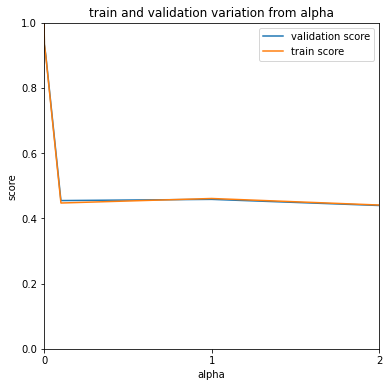

In [10]:
#PS : use_idf ou non change pas bcp
#Changement d'alpha

alpha_range = [0.00001,0.0001,0.001,0.01,0.1,1.0,2.0]

trainList = []
testList = []

for A in alpha_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        random_state=42,alpha=A,
                          max_iter=5, tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))

print("score des tests :")
print(testList)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.xlim(0,2)
ax.set_ylim([0,1])
plt.xticks(range(0,3))
ax.set_title('train and validation variation from alpha');
plt.xlabel('alpha')
plt.ylabel('score') 
ax.plot(alpha_range,testList, label="validation score")
ax.plot(alpha_range,trainList, label="train score")
ax.legend()

In [11]:
#Loss
loss_range = ['hinge','log','modified_huber','squared_hinge','perceptron']


trainList = []
testList = []

for L in loss_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss=L, penalty='l2',
                        random_state=42,
                          max_iter=5,tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))

ptable = pd.DataFrame([trainList,testList], columns=loss_range,index=["train score","validation score"])
display(ptable)

,hinge,log,modified_huber,squared_hinge,perceptron
train score,0.975452,0.932483,0.987292,0.896998,0.999416
validation score,0.969784,0.937053,0.976691,0.912274,0.979508


In [12]:
#Penalty

penalty_range = ['l2','l1','elasticnet']

trainList = []
testList = []

for P in penalty_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty=P,
                        random_state=42,
                          max_iter=5,tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))
    
ptable = pd.DataFrame([trainList,testList], columns=penalty_range,index=["train score","validation score"])
display(ptable)


,l2,l1,elasticnet
train score,0.975452,0.957262,0.964515
validation score,0.969784,0.956837,0.963868


#### Recherche avec GridSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
#Prend enormement de temps

classifier = SGDClassifier()

param = {'loss' : ['hinge','modified_huber','perceptron'], 
         'penalty' : ['l2'], 
         'random_state' : [42], 
         'max_iter' : [5],
         'tol' : [None], 
         'alpha' : [0.000001,0.00001,0.0001,0.001]}
gscv = GridSearchCV(classifier, param)

clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', gscv),
])
clf = clf.fit(train["content"], train["lang"])
print("Fin du train")

Fin du train


Meilleurs hyperparametres trouves :
{'alpha': 1e-05, 'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l2', 'random_state': 42, 'tol': None}




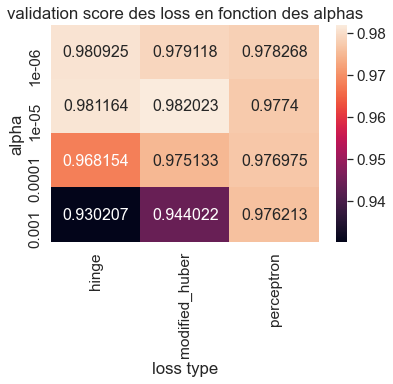

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

print("Meilleurs hyperparametres trouves :")
print(gscv.best_params_)
print()
print()

values = []

columns = ['hinge','modified_huber','perceptron']

i=0
for a in np.unique(gscv.cv_results_['param_alpha']):
    valY = []
    for l in np.unique(gscv.cv_results_['param_loss']):
        valY.append(gscv.cv_results_['mean_test_score'][i])
        i = i+1
    values.append(valY)

    
ptable = pd.DataFrame(values, columns=columns,index=[0.000001,0.00001,0.0001,0.001])

# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(ptable, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel("loss type")
plt.ylabel("alpha")
plt.title("validation score des loss en fonction des alphas")
plt.show()

Nous choisirons donc
- un alpha de 0.00001 afin de s'assurer d'un bon score sans trop diminuer pour eviter l'overfit
- un loss function de type : 'modified huber'
- une penalty de type : 'l2'

In [51]:
#Choisi :
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(alpha=0.00001,loss='modified_huber', penalty='l2',
                        random_state=42,
                          max_iter=5,tol=None)),
])
clf = clf.fit(train["content"], train["lang"])

print("train score :",clf.score(train["content"],train["lang"]))
print("valid score :",clf.score(valid["content"],valid["lang"]))
print("test score :",clf.score(test["content"],test["lang"]))

train score : 0.9988575982996812
valid score : 0.9834218916046759
test score : 0.9821466524973432


# Analyse des resultat et des metriques

In [17]:
#Prend pas mal de temps

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import numpy as np

from sklearn.model_selection import KFold, cross_val_score

scores = cross_val_score(
    clf, train["content"], train["lang"], cv=5)

print("differents scores cross_validate : ")
print(scores)
print("moyenne des scores :",np.mean(scores))

print("train score :",clf.score(train["content"],train["lang"]))
print("valid score : ",clf.score(valid["content"],valid["lang"]))

differents scores cross_validate : 
[0.98109281 0.98255402 0.9834396  0.98286397 0.9815356 ]
moyenne des scores : 0.9822972015586255
train score : 0.9988575982996812
valid score :  0.9834218916046759


In [18]:
#Attention prend beaucoup de temps

cross_v = cross_validate(clf, train["content"], train["lang"], cv=5, return_train_score=True)
print(cross_v)

{'fit_time': array([16.48648858, 14.29972863, 13.68614244, 13.53668189, 13.29801917]), 'score_time': array([3.00511456, 2.39835119, 2.07936692, 2.13546824, 2.2846849 ]), 'test_score': array([0.98109281, 0.98255402, 0.9834396 , 0.98286397, 0.9815356 ]), 'train_score': array([0.99909228, 0.99908121, 0.99910335, 0.99897051, 0.99914763])}


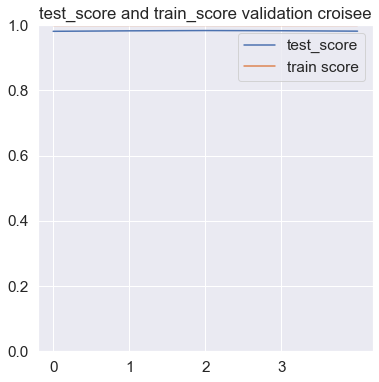

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_ylim([0,1])
plt.xticks(range(0,4))
ax.plot(cross_v['test_score'],label = "test_score")
ax.set_title('test_score and train_score validation croisee');
ax.plot(cross_v['train_score'], label="train score")
ax.legend()

In [52]:
y_true = test["lang"]
y_pred = clf.predict(test["content"])

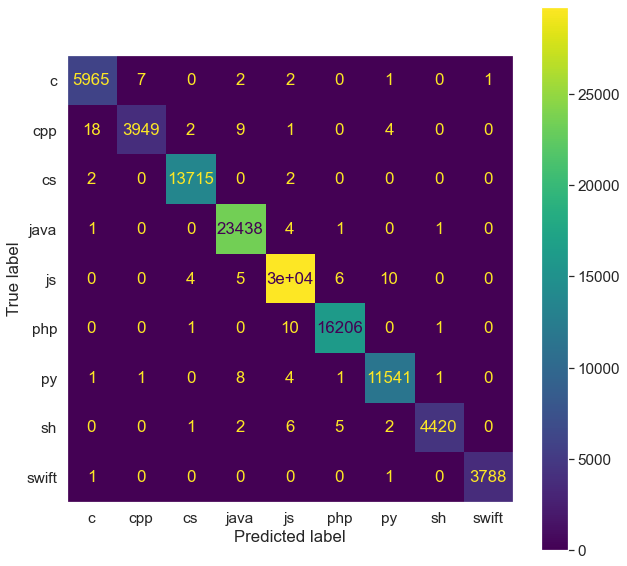

In [63]:

# Matrice de confusion
#print(confusion_matrix(y_true, y_pred, labels=lang))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, train["content"], train["lang"], ax=ax)
plt.grid(False)
plt.show()

In [22]:
#MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true,y_pred)
print(mcc)

0.9801567566102147


In [23]:
y_true =  valid["lang"]
y_pred = clf.predict(valid["content"])
target_names = lang
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          js       0.93      0.96      0.94      2989
          cs       0.94      0.87      0.90      1931
        java       0.99      1.00      0.99      6835
         php       0.99      1.00      0.99     11677
          py       0.99      0.99      0.99     14745
           c       0.99      0.99      0.99      8170
          sh       0.98      0.98      0.98      5968
         cpp       0.98      0.97      0.97      2295
       swift       1.00      0.98      0.99      1850

    accuracy                           0.98     56460
   macro avg       0.98      0.97      0.97     56460
weighted avg       0.98      0.98      0.98     56460



## Tests persos

In [24]:
clf.predict([
"public class Main{ \
    public static void main(String[] args) {\
    System.out.println(\"blabla\");\
    }"
    ])[0]

'java'

In [25]:
clf.predict([
"\
#include <iostream>\
#define e using\
#define ee namespace\
#define eee std\
#define eeee ;\
#define eeeee int\
#define eeeeee main\
#define eeeeeee (\
#define eeeeeeee )\
#define eeeeeeeee while\
#define eeeeeeeeee true\
#define eeeeeeeeeee {\
#define eeeeeeeeeeee }\
#define eeeeeeeeeeeee cout\
#define eeeeeeeeeeeeee cerr\
#define eeeeeeeeeeeeeee <<\
#define eeeeeeeeeeeeeeee 'e'\
#define eeeeeeeeeeeeeeeee return\
\
e ee eee eeee\
eeeee eeeeee eeeeeee eeeeeeee\
eeeeeeeeeee\
eeeeeeeee eeeeeee eeeeeeeeee eeeeeeee\
eeeeeeeeeee\
eeeeeeeeeeeee eeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeeeee eeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeee\
eeeeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeee"
    ])[0]

'cpp'